# Predict hospital equipment needs in major cities in the United States
---

## Introduction

### Problem Statement
**Compare top cities in the United States with respect to business prospects for a hospital equipment seller**

---
### Background

In the wake of new health emergencies, countries health system is going through a crisis. Some cities are worse than others with respect to availability of hospitals with critical care. As these cities ramp up to handle the current crisis as well to be prepared for the future, they'll need to build new hospitals and equip existing ones with the necessary equipment.
A seller for multiple brands of hospital critical care equipment would also have to scale up to be able to grab the available opportunities to sell. Since it's a time of crisis, he has to make the equipment instantly. 
He will find it very useful to be able to estimate the demand in advance. He can keep the inventory ready  in the same city to shorten the delivery time and create a competitive advantage.

Current health crisis is a contagious one and is expected to be a major issue in bigger cities. More populated cities may expect more spread of the disease and the sheer number will overwhelm their health systems. And these cities will also be able to arrange funding and start gearing up sooner. 
These more populous metropolitan areas in the country are definitely the best places for this business. We'll try to find areas where we see a deficit and may need to build new hospitals or expand existing ones.

We will pick the most populous cities in the United States for analysis. We will find out how these cities compare with respect to hospital availability 
We will go through each step of this project and address them separately. I first outline the initial data preparation and describe future steps.


**Target Audience**


What type of clients or a group of people would be interested in this project?
Business personnel with interests in hospitals and related areas. For example medical equipment sellers, construction companies, sanitation contractors, ambulance operators etc
This analysis will be a comprehensive guide to start or expand their businesses targeting the large pool of new hospitals that may come up.

---

## Data

In order to answer the above questions we need the following data
1. List of cities in the United States with population
2. For each city number of hospitals and geo location data for each hospital

List of cities with population data will be obtained from the website - https://www.nlc.org/the-30-most-populous-cities
All data related to number of hospitals in each city and locations of each hospital will be obtained via the FourSquare API utilized via the Request library in Python.

---

## Methodology

- Cities and population data will be collected from https://www.nlc.org/the-30-most-populous-cities and cleaned and processed into a dataframe.
- FourSquare be used to locate all hospitals in each of the cities. Hospital details with geolocation data is added to the dataframe.
- Data is processed to calculate additional values like hospital density for each city
- Finally, the data be will be visually assessed using graphing from various Python libraries.

---

## Code

### 1. Import necessary libraries

In [5]:
import numpy as np
import pandas as pd
import requests
import folium
import json
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Scrape the web for the list of cities by population

For the sake of this assignment we'll restrict to 10 cities

In [6]:
url='https://www.nlc.org/the-30-most-populous-cities'

df_cities = pd.read_html(url, header=0)[0]
df_cities.rename(columns={'City Name': 'City'}, inplace=True)
state = df_cities["State"].copy() 
df_cities["City"]= df_cities["City"].str.cat(state, sep =", ") 
df_cities.drop(columns=['Rank', 'State'], inplace=True)
df_cities.set_index('City', inplace=True)

df_cities["Hospitals"] = np.nan
df_cities["Hospital / 1000 People"] = np.nan

# Select the top 10 cities for this assignment
df_cities = df_cities.head(10)
cities = list(df_cities.index) 

print('Cities being analyzed\n' + ','.join(cities))

Cities being analyzed
New York, NY,Los Angeles, CA,Chicago, IL,Houston, TX,Philadelphia, PA,Phoenix, AZ,San Antonio, TX,San Diego, CA,Dallas, TX,San Jose, CA


### 3. Use Foursquare API to get the list of Hospitals in each city

Create a dataframe with number of hospitals and geolocation

In [7]:
# Foursquare API credentials
CLIENT_ID = 'JWBOF0YK2PNJES2M22WBZJ0FEIEJYRBZQZULWQS0YVUXQLMX'
CLIENT_SECRET = 'YQPUTH2CH3024COEXIEDNNTKMC3ASUXWLR2ALKVPT3LFSHFZ'
VERSION = '20200315'
LIMIT = 500
results = {}
maps = {}
city_lat = 0
city_lng = 0
counts = {}
# Loop through all the cities
for city in cities:
    offset = 0
    total_venues = 0
    results[city] = pd.DataFrame(columns = ['name','lat', 'lng'])
    # Invoke foursquare API multiple times to get the complete list for a city
    while (True):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&limit={}&categoryId={}&offset={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            city,
            LIMIT,
            '4bf58dd8d48988d196941735', #Hospitals
            offset
            ) 
        
        result = requests.get(url).json()
        venues = result['response']['groups'][0]['items']
        venues_fetched = len(venues)
        total_venues = total_venues + venues_fetched

        city_lat = np.mean([result['response']['geocode']['geometry']['bounds']['ne']['lat'],
                        result['response']['geocode']['geometry']['bounds']['sw']['lat']])
        city_lng = np.mean([result['response']['geocode']['geometry']['bounds']['ne']['lng'],
                        result['response']['geocode']['geometry']['bounds']['sw']['lng']])
                            
        venues = pd.json_normalize(venues)

        # Pick only columns you need
        filtered_columns = ['venue.name', 'venue.location.lat', 'venue.location.lng']
        venues = venues.loc[:, filtered_columns]

        # Remove special characters from column names
        venues.columns = [col.split(".")[-1] for col in venues.columns]
        results[city] = pd.concat([results[city], venues], axis = 0, sort = False)

        if (venues_fetched < 100):
            break
        else:
            offset = offset + 100
    results[city] = results[city].reset_index(drop = True)
#     print("Number of Hospitals in {} : {}".format(city, total_venues))
    df_cities.at[city, 'Hospitals'] = total_venues

    # Create maps for each city
    maps[city] = folium.Map(location = [city_lat, city_lng], zoom_start = 13)
    for name, latitude, longitude in zip(results[city]['name'], results[city]['lat'], results[city]['lng']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html = True)
        folium.CircleMarker(
            [latitude, longitude],
            radius = 5,
            popup = label,
            color = 'green',
            fill = True,
            fill_color = '#3186cc',
            fill_opacity = 0.7,
            parse_html = False).add_to(maps[city])  

#     maps[city].save("Venues by Foursquare.html")
    
# df_cities.drop(columns=["level_0"], inplace=True)
df_cities.reset_index(inplace = True) 

# Calculate hospital density in each city
df_cities["Hospital / 1000 People"] = df_cities["Hospitals"] / df_cities['Population'] * 1000

print('\nHospitals Data')
print(df_cities.head(10))


Hospitals Data
               City  Population  Hospitals  Hospital / 1000 People
0      New York, NY     8175133      258.0                0.031559
1   Los Angeles, CA     3792621      206.0                0.054316
2       Chicago, IL     2695598      202.0                0.074937
3       Houston, TX     2099451      211.0                0.100502
4  Philadelphia, PA     1526006      164.0                0.107470
5       Phoenix, AZ     1445632      189.0                0.130739
6   San Antonio, TX     1327407      173.0                0.130329
7     San Diego, CA     1307402      156.0                0.119321
8        Dallas, TX     1197816      191.0                0.159457
9      San Jose, CA      945942       89.0                0.094086


### 4. Draw charts based on the data to compare visually

Create charts for population, number of hospitals and hospital density

Text(0.5, 0.98, 'Hospital density across selected cities')

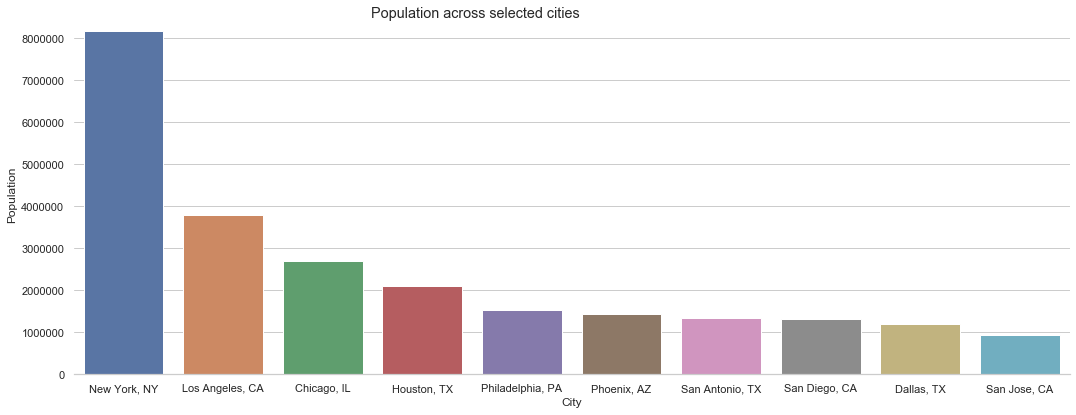

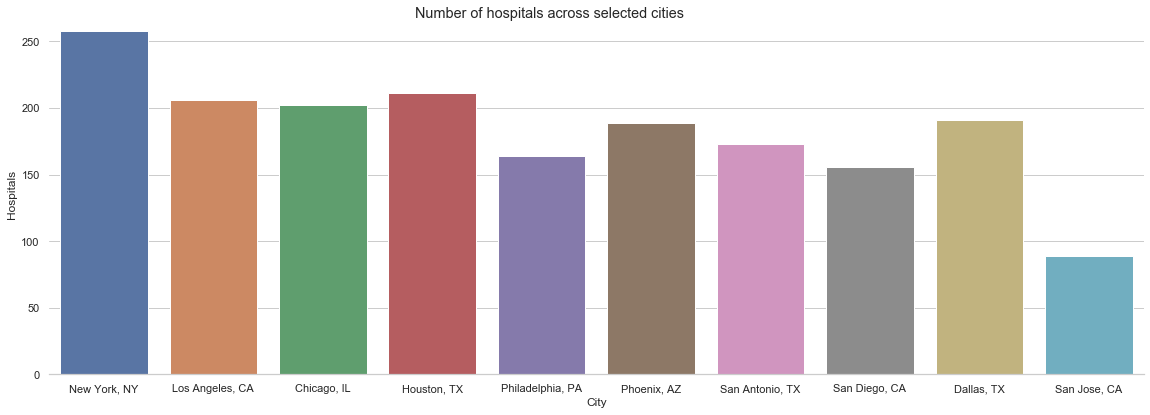

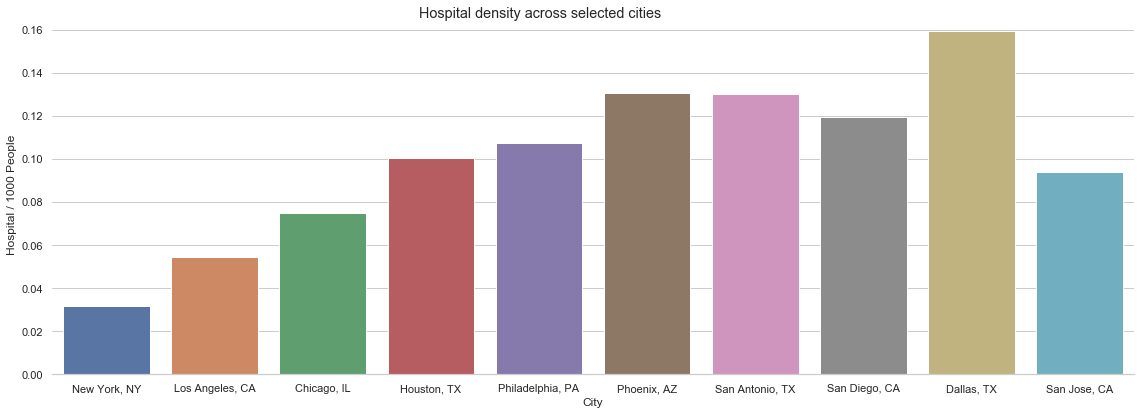

In [8]:
# Compare population across selected cities
sns.set(style="whitegrid")
g = sns.catplot(x='City', y='Population', data=df_cities, kind='bar')
g.despine(left=True)
g.fig.set_figwidth(20)
g.fig.set_figheight(6)
g.set_ylabels("Population")
g.fig.suptitle('Population across selected cities')

# Compare number of hospitals across selected cities
g = sns.catplot(x='City', y='Hospitals', data=df_cities, kind='bar')
g.despine(left=True)
g.fig.set_figwidth(20)
g.fig.set_figheight(6)
g.set_ylabels("Hospitals")
g.fig.suptitle('Number of hospitals across selected cities')

# Compare hospital density across selected cities
g = sns.catplot(x='City', y='Hospital / 1000 People', data=df_cities, kind='bar')
g.despine(left=True)
g.fig.set_figwidth(20)
g.fig.set_figheight(6)
g.set_ylabels("Hospital / 1000 People")
g.fig.suptitle('Hospital density across selected cities')

In the charts above we can see that number of hospitals is not proportional to the population in the cities.
Last chart shows the density of hospitals. The cities with the least number of hospitals per 1000 people might need to ramp up their health systems

### 5. Use Foursquare API to get the list of categories and find the category id

In [9]:
# Retreive list of categories from foursquare API
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
# cats = requests.get(url) #.json()
# print(url)
df = pd.read_json(url)
df = df['response']['categories']
# df
df = pd.DataFrame(df)
df.head()

# dff = df.loc[df['name'] == 'Meadery']
# dff['categories']
# unwrapped = []
# unwrap_list(df, unwrapped)
# test = iterdict(unwrapped)
# print('Done ' + test)
# unwrapped

,id,name,pluralName,shortName,icon,categories
0,4d4b7104d754a06370d81259,Arts & Entertainment,Arts & Entertainment,Arts & Entertainment,{'prefix': 'https://ss3.4sqi.net/img/categorie...,"[{'id': '56aa371be4b08b9a8d5734db', 'name': 'A..."
1,4d4b7105d754a06372d81259,College & University,Colleges & Universities,College & Education,{'prefix': 'https://ss3.4sqi.net/img/categorie...,"[{'id': '4bf58dd8d48988d198941735', 'name': 'C..."
2,4d4b7105d754a06373d81259,Event,Events,Event,{'prefix': 'https://ss3.4sqi.net/img/categorie...,"[{'id': '52f2ab2ebcbc57f1066b8b3b', 'name': 'C..."
3,4d4b7105d754a06374d81259,Food,Food,Food,{'prefix': 'https://ss3.4sqi.net/img/categorie...,"[{'id': '503288ae91d4c4b30a586d67', 'name': 'A..."
4,4d4b7105d754a06376d81259,Nightlife Spot,Nightlife Spots,Nightlife,{'prefix': 'https://ss3.4sqi.net/img/categorie...,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B..."


### 6. Get each hospital location through Foursquare API

In [10]:
# type your answer here
LIMIT = 500
results = {}
pd.options.mode.chained_assignment = None
for city in cities:
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        city,
        LIMIT,
        '4bf58dd8d48988d196941735') #Hospitals
    results[city] = requests.get(url).json()

df_venues={}
for city in cities:
    venues = pd.json_normalize(results[city]['response']['groups'][0]['items'])
    df_venues[city] = venues[['venue.name', 'venue.location.address', 'venue.location.lat', 'venue.location.lng', 'venue.location.formattedAddress']]
    df_venues[city].columns = ['Name', 'Address', 'Lat', 'Lng', 'Zip']
    df_venues[city]['Zip'] = df_venues[city]['Zip'].str.extract(r'(\d{5}\-?\d{0,4})')

maps = {}
for city in cities:
    city_lat = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lat'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lat']])
    city_lng = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lng'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lng']])
    maps[city] = folium.Map(location=[city_lat, city_lng], zoom_start=11)
    maps[city].save(city + '.jpg')
    # add markers to map
    for lat, lng, label in zip(df_venues[city]['Lat'], df_venues[city]['Lng'], df_venues[city]['Name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(maps[city])  
    print(f"Total number of Hospitals places in {city} = ", results[city]['response']['totalResults'])

Total number of Hospitals places in New York, NY =  258
Total number of Hospitals places in Los Angeles, CA =  206
Total number of Hospitals places in Chicago, IL =  229
Total number of Hospitals places in Houston, TX =  237
Total number of Hospitals places in Philadelphia, PA =  164
Total number of Hospitals places in Phoenix, AZ =  189
Total number of Hospitals places in San Antonio, TX =  173
Total number of Hospitals places in San Diego, CA =  186
Total number of Hospitals places in Dallas, TX =  191
Total number of Hospitals places in San Jose, CA =  89


### 7. Visualize hospital locations on each city map

In [11]:
print('Hospitals in', cities[0])
maps[cities[0]]

Hospitals in New York, NY


In [12]:
print('Hospitals in', cities[1])
maps[cities[1]]

Hospitals in Los Angeles, CA


In [13]:
print('Hospitals in', cities[2])
maps[cities[2]]

Hospitals in Chicago, IL


In [14]:
print('Hospitals in', cities[3])
maps[cities[3]]

Hospitals in Houston, TX


In [15]:
print('Hospitals in', cities[4])
maps[cities[4]]

Hospitals in Philadelphia, PA


In [16]:
print('Hospitals in', cities[5])
maps[cities[5]]

Hospitals in Phoenix, AZ


In [17]:
print('Hospitals in', cities[6])
maps[cities[6]]

Hospitals in San Antonio, TX


In [18]:
print('Hospitals in', cities[7])
maps[cities[7]]

Hospitals in San Diego, CA


In [19]:
print('Hospitals in', cities[8])
maps[cities[8]]

Hospitals in Dallas, TX


In [20]:
print('Hospitals in', cities[9])
maps[cities[9]]

Hospitals in San Jose, CA


---

## Results and Discussion

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any business person.

We scraped the web for a list of most populous cities in the United States. For this assignment we picked the top 10 cities.
For each of these cities we used the Foursquare API to get the number of hospitals and the details of each hospital such as latitude and longitude values
After collecting data from the Foursquare and web, we got a list of 120 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their  as well as names to combine them and remove all the outliers. This collected a number of records for each of the 10 cities

We processed the data to calculate hospital density in each city and compared them visually along with population data and number of hospitals
For each city hospital locations were plotted on the map. This provides clue as to how the hospitals are scattered in each of the cities. Further analysis can be done at a more granular neighbourhood level to suggest ideal locations for new hospitals

Hospital equipment seller who's looking for cities which may need to set up more hospitals will find New York as the right place

---

## Conclusion
The purpose of this project was to compare the cities in the United States with respect to the business prospects for a hospital equipment seller. The cities have been identified using Foursquare and data from web scraping and have been plotted on bar charts and on the maps. These plots reveals that New York has the least number of hospitals per 1000 people.
To prepare for current or future health crisis, New York may have to invest more in their health systems. This may have to be taken up sooner and provides the right information to the hospital equipment seller to take the right business actions and to optimize his inventory

---
